In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import Model, utils
from tensorflow.compat.v1.keras.layers import Layer, Input, Conv2D, ReLU, Concatenate, BatchNormalization, MaxPool2D, AvgPool2D, UpSampling2D

In [2]:
class ConvBlock(Layer):
    def __init__(self, filters, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters        
        with tf.variable_scope(self.name):
            self.bn = BatchNormalization() 
            self.conv2d = Conv2D(filters=filters, kernel_size=(3, 3), padding="same")
            self.relu = ReLU()
            self.concat = Concatenate(axis=-1)
        
    def call(self, x, training=False):
        x_in = x
        x = self.bn(x, training=training) 
        x = self.conv2d(x)
        x = self.relu(x)
        x_out = self.concat([x_in, x])
        return x_out
    
    def get_config(self):
        return {}

class DenseBlock(Layer):    
    def __init__(self, num_layers, filters, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.filters = filters
        self.num_layers = num_layers
        with tf.variable_scope(self.name):
            self.layers = [ConvBlock(self.filters) for i in range(self.num_layers)]
    
    def call(self, x, training=False):
        for layer in self.layers:
            x = layer(x, training=training)
        return x
    
    def get_config(self):
        return {}

class TransitionBlock(Layer):
    def __init__(self, filters, trans_down=True, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.filters = filters
        self.trans_down = trans_down
        with tf.variable_scope(self.name):
            self.bn = BatchNormalization()
            self.relu = ReLU()
            self.conv2d = Conv2D(filters=filters, kernel_size=(1, 1), padding="same")
            self.pool2d = AvgPool2D(pool_size=2, strides=2) if trans_down else UpSampling2D(size=(2, 2))
    
    def call(self, x, training=False):
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.conv2d(x)
        x = self.pool2d(x)
        return x
    
    def get_config(self):
        return {}

In [13]:
def get_denseNet(input_shape, num_db, num_channels=64, growth_rate=32, convs_per_db=3, model_name="DenseNet", **kwargs):
    assert len(input_shape) > 1
    assert (input_shape[0] % 2 == 0) and (input_shape[1] % 2 == 0)
    assert (num_db > 1) and (num_db % 2 == 1)
    assert (num_channels > 0) and (num_channels % 2 == 0)
    
    num_trans_down = num_trans_up = num_db//2
    db_outputs = []
    
    img_in = Input(dtype="float32", shape=input_shape, name="image_input")
    x = Conv2D(growth_rate, kernel_size=(5, 5), activation="relu", padding="same")(img_in)
    # Transition down section
    for i in range(num_trans_down):
        x_in = x
        x = DenseBlock(num_layers=convs_per_db, filters=growth_rate)(x)
        x = Concatenate(axis=-1)([x_in, x])
        db_outputs.insert(0, x)
        num_channels += growth_rate*i
        num_channels //= 2
        x = TransitionBlock(filters=num_channels, trans_down=True)(x)
    # Mid DenseBlock
    x = DenseBlock(num_layers=convs_per_db, filters=growth_rate)(x)
    # Transition up section
    for i in range(num_trans_up):
        num_channels += growth_rate*(i+1)
        num_channels //= 2
        x = TransitionBlock(filters=num_channels, trans_down=False)(x)
        x = Concatenate(axis=-1)([x, db_outputs[i]])
        x = DenseBlock(num_layers=convs_per_db, filters=growth_rate)(x)
    # TODOs: Configure output layer arguments 
    x_out = Conv2D(1, kernel_size=(5, 5), activation="sigmoid", padding="same", name="image_output")(x)
    model = Model(inputs=[img_in], outputs=[x_out], name=model_name)
    return model

In [14]:
input_shape = (8, 8, 1)
data = np.random.random(size=(2, *input_shape))

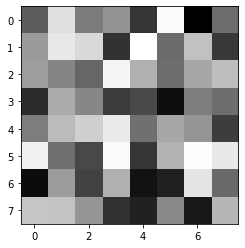

In [15]:
plt.imshow(data[0], cmap="binary")

In [18]:
tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    denseNet = get_denseNet(input_shape, num_db=5)
    tf.summary.FileWriter("temp", sess.graph)
    denseNet.summary()
    utils.plot_model(denseNet, show_shapes=True)
    out_data = denseNet.predict(data)

Model: "DenseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 8, 8, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 32)     832         image_input[0][0]                
__________________________________________________________________________________________________
dense_block (DenseBlock)        (None, 8, 8, 128)    56160       conv2d[0][0]                     
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 8, 8, 160)    0           conv2d[0][0]                     
                                                                 dense_block[0][0]         

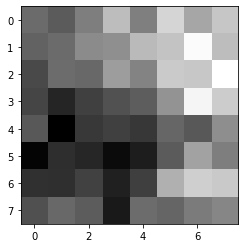

In [19]:
plt.imshow(out_data[0, :, :, 0], cmap="binary")

In [20]:
%load_ext tensorboard
%tensorboard --logdir temp

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 18842), started 0:03:09 ago. (Use '!kill 18842' to kill it.)